#Machine learning with Python by IBM

We will be looking at different classifers in this notebook: KNN, SVM, Tree and Logistic Reg.
Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


#Importing TRAIN DATA SHEET
we will be using data sheet related past loans. The loan_train.csv data sheet will be used for training the model for diiferent classifers.
We will download the datasheet using the following command.

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv


--2020-04-01 10:44:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-04-01 10:44:16 (13.3 MB/s) - ‘loan_train.csv’ saved [23101/23101]



#loading data from csv file

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


#Convert dates using to_datetime
we will convert provided data about due_date and effective_date using the to_datetime command

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])

In [5]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


#Data visualization and pre-processing
let us now take a deeper look into our given data. we need to understand the number of people in features.

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [7]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

In [8]:
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



#Data visualization

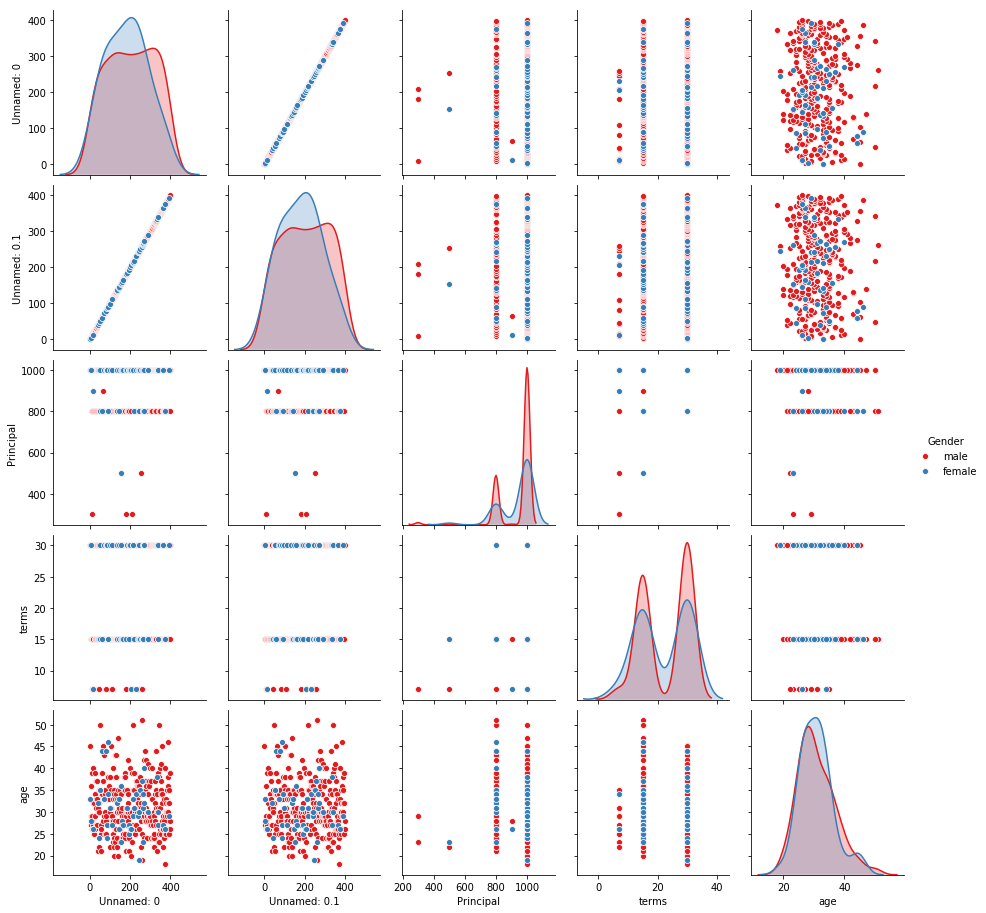

In [9]:
import seaborn as sns 
bins=np.linspace(df.Principal.max(),df.Principal.min(),10)
g=sns.pairplot(df,hue="Gender",palette="Set1")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff851b19470>]],
      dtype=object)

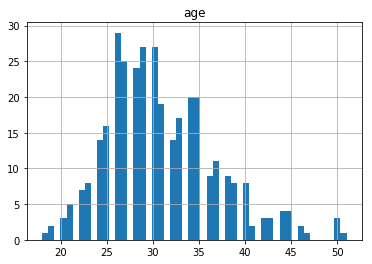

In [10]:
df.hist(column='age', bins=50)

In [11]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

#PRE-PROCESSING:: FEATURE selection
we will now select the features we need for training our model and we will convert the str to binarys were needed for model training

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Because Master or Above are only two we will exclude this from our training set.

In [15]:
len(df[df.education=='Master or Above'])

2

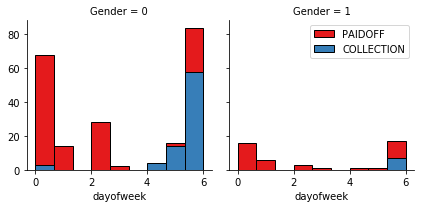

In [16]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [17]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [18]:
Feature = df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,0,1,0
1,1000,30,33,1,0,3,1,0,0
2,1000,15,27,0,0,3,0,0,1
3,1000,30,28,1,1,4,0,0,1
4,1000,30,29,0,1,4,0,0,1


In [20]:
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
y[0:5]

array([0, 0, 0, 0, 0])

#Normalize Data¶
Data Standardization give data zero mean and unit variance.

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

#Classification
we are done with cleaning and preprocessing our dataset now we will apply train-test split on the following classifers to build a training model
1)K Nearest Neighbor(KNN)
2)Decision Tree
3)Support Vector Machine
4)Logistic Regression

#Train-Test split

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


#K-NN MODEL

In [23]:
from sklearn.neighbors import KNeighborsClassifier
# Importing the metrics
from sklearn import metrics


In [24]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.67142857, 0.77142857, 0.71428571, 0.74285714, 0.72857143,
       0.75714286, 0.72857143, 0.74285714, 0.7       , 0.71428571,
       0.67142857])

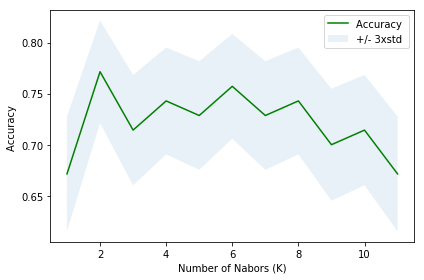

In [25]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [26]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with k= 2


In [27]:
n=mean_acc.argmax()+1
neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
yhat = neigh.predict(X_test)
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
TrainKNNJ=jaccard_similarity_score(y_test, yhat)
TrainKNNf=f1_score(y_test, yhat, average='weighted')

#Decision Tree

In [28]:
from sklearn import tree
import matplotlib.image as mpimg
#Modelling of Decision Tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
#predicting of Decision Tree
y_pred=clf_tree.predict(X_test)

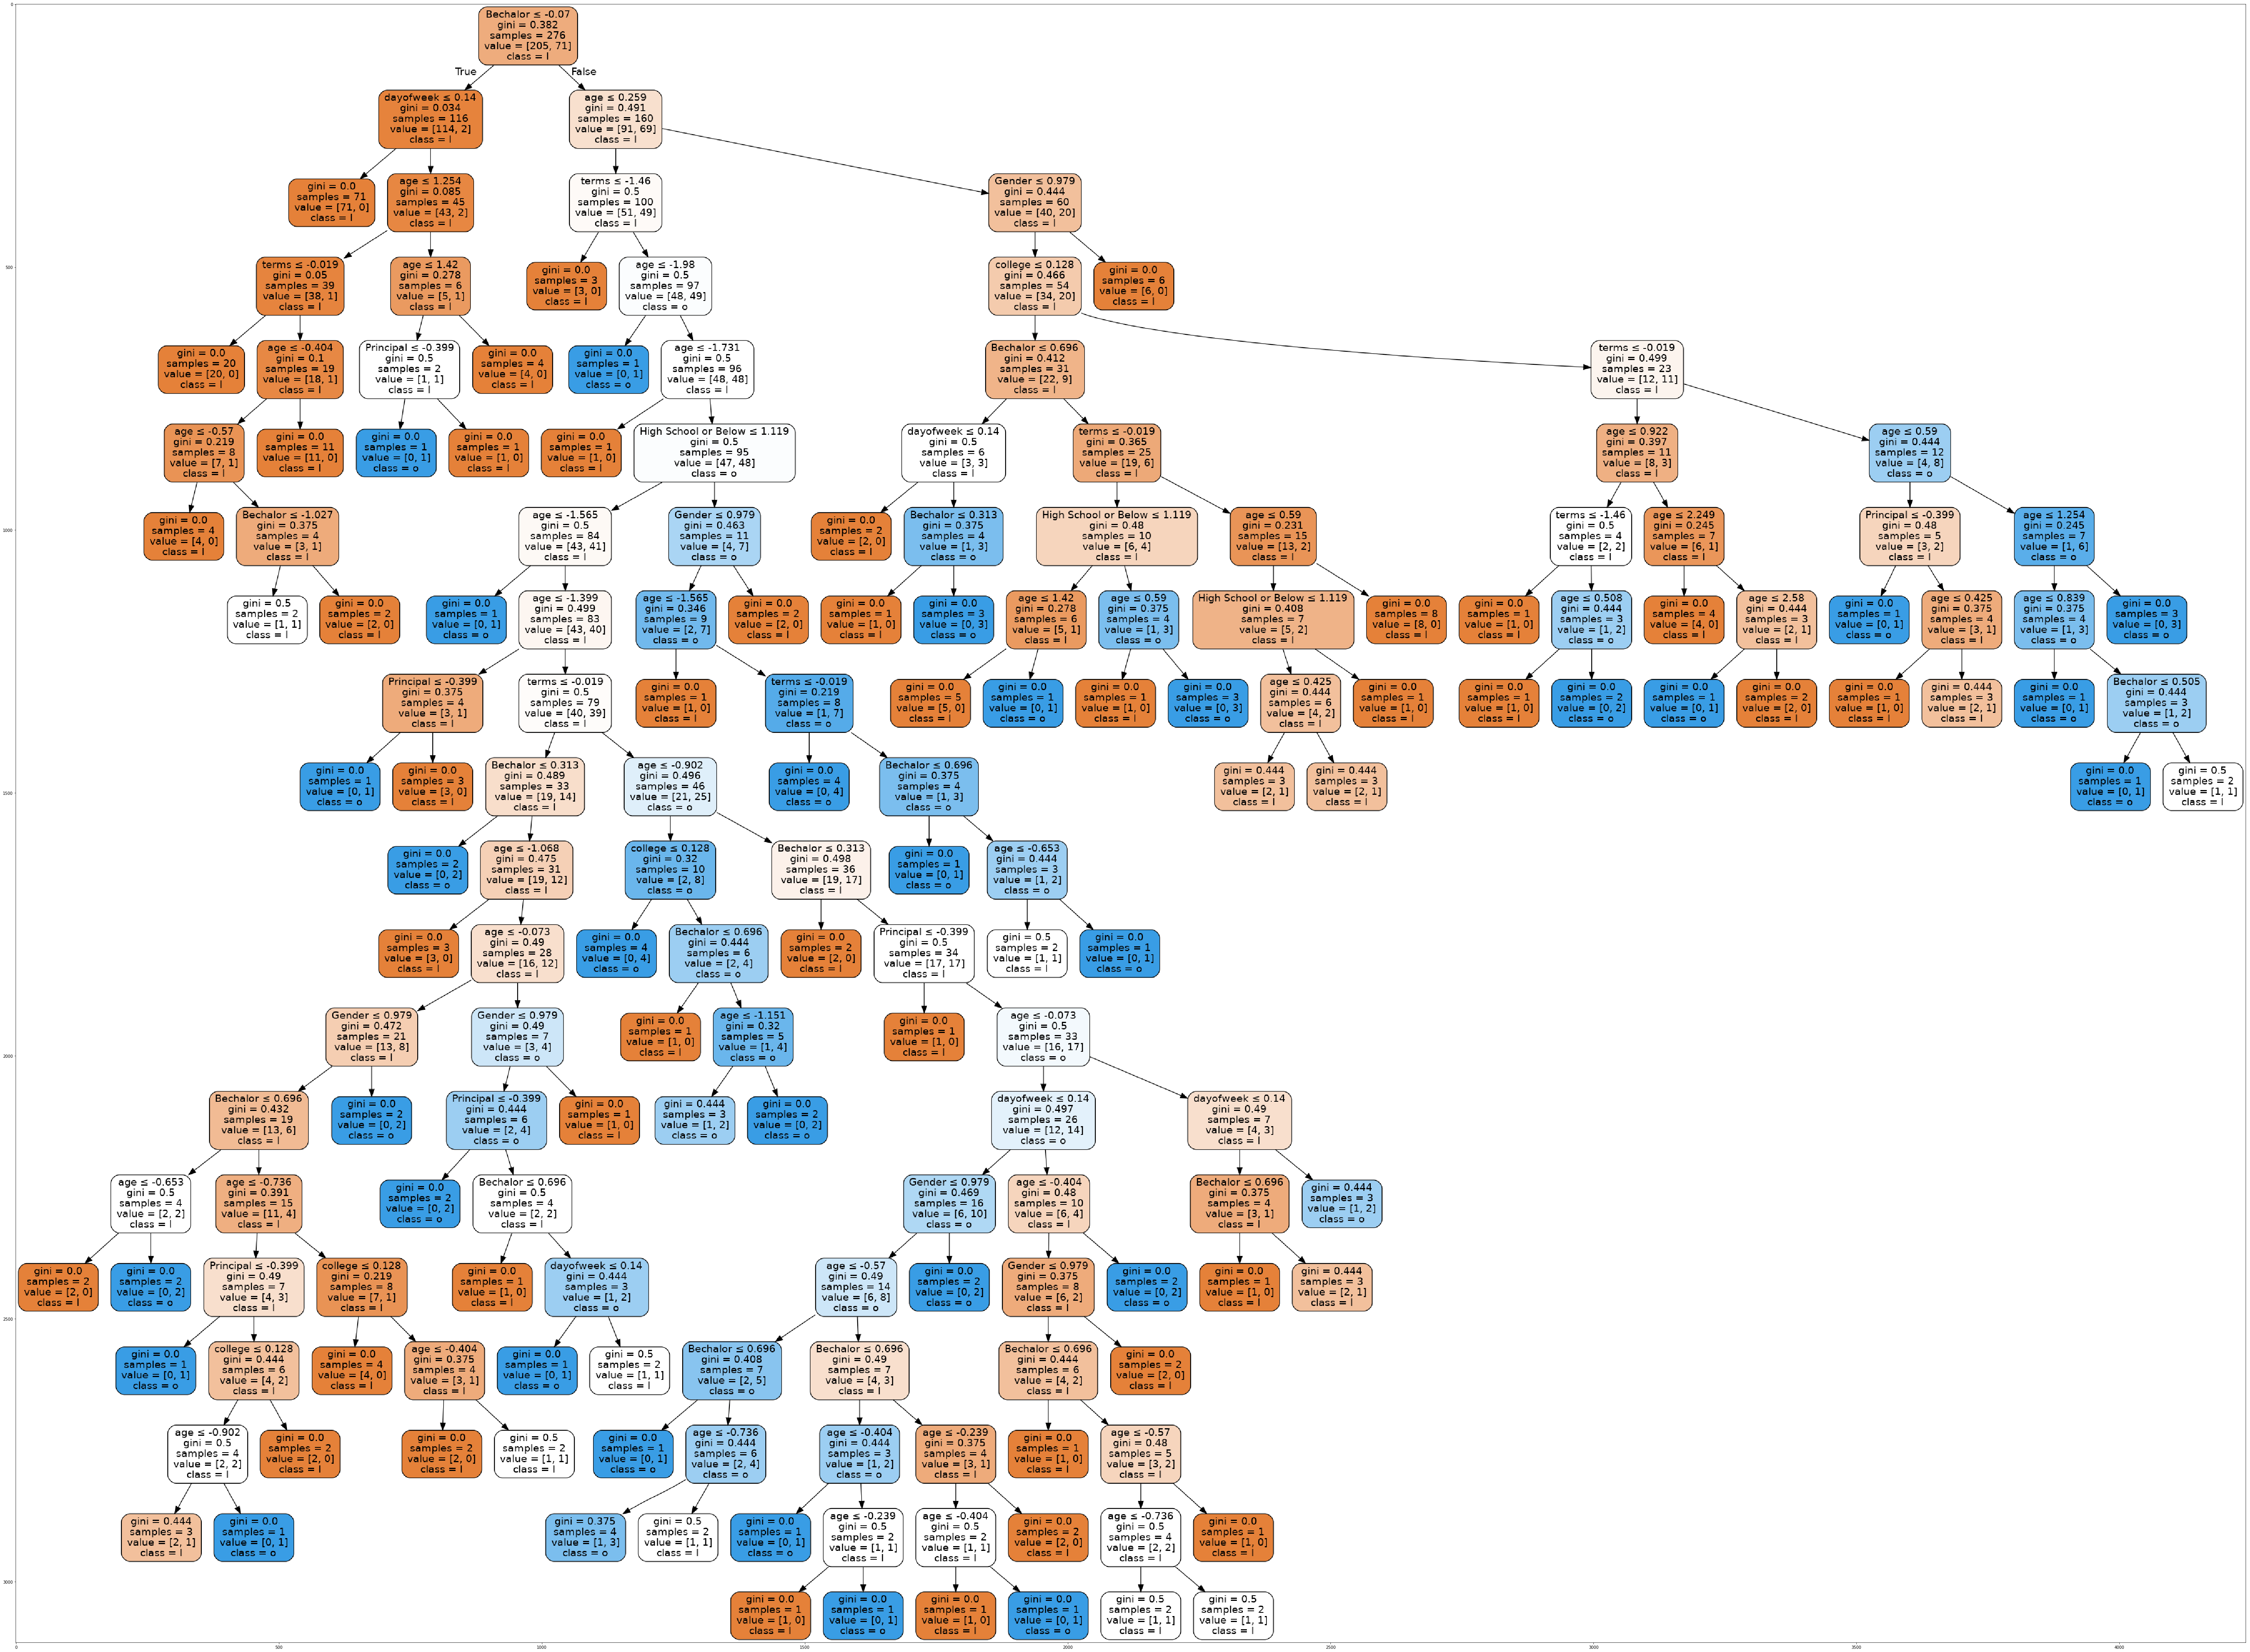

In [29]:
!pip install graphviz
!pip install pydotplus
import graphviz 
import pydotplus

dot_data = tree.export_graphviz(clf_tree, out_file=None,feature_names=['Principal','terms','age','Gender','weekend','Bechalor','High School or Below','college','dayofweek'],  
                     class_names='loan_status',filled=True, rounded=True,special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("tree.png")
img = mpimg.imread("tree.png")
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

In [30]:
TrainTreeJ=jaccard_similarity_score(y_test, y_pred)
TrainTreef=f1_score(y_test, y_pred, average='weighted')


#Support Vector Machine

In [31]:
y_train=y_train.astype(float)
from sklearn import svm
#Modelling using SVM
clf3 = svm.LinearSVC(random_state=7)
clf3.fit(X_train, y_train)  
#Predicition using SVM
y_pred=clf3.predict(X_train)
TrainSVMJ=jaccard_similarity_score(y_train, y_pred)
TrainSVMf=f1_score(y_train, y_pred, average='weighted')

#Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
#Modelling and training
clf4 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf4.fit(X_train, y_train)
#prediciting
y_pred=clf4.predict(X_test)
y_proba=clf4.predict_proba(X_test)
#Error calculations
TrainLogRegJ=jaccard_similarity_score(y_test, y_pred)
TrainLogRegf=f1_score(y_test, y_pred, average='weighted')  
TrainLogRegLL=log_loss(y_test,y_proba)

#Represntation of results after training
The follwoing table shows the results after training of the dataset

In [33]:
list_JC = [TrainKNNJ,TrainTreeJ,TrainSVMJ,TrainLogRegJ]
list_FS = [TrainKNNf,TrainTreef, TrainSVMf, TrainLogRegf]
list_LL = ['NA', 'NA', 'NA',TrainLogRegLL]

df = pd.DataFrame(list_JC, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_FS)
df.insert(loc=2, column='LogLoss', value=list_LL)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.771429,0.737618,NA
Decision Tree,0.757143,0.746875,NA
SVM,0.771739,0.745688,NA
Logistic Regression,0.714286,0.685961,0.508096


#Testing model
We are done with trainin gthe model using training set we will now proceed to checking our model using test dataset.
we will download the test data sheet using the follwoing command

In [34]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-01 10:47:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-01 10:47:50 (392 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [36]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

In [37]:
X = Feature
y = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
testy=y.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X)

#KNN testing
knn_pred=neigh.predict(testX)
KNNJ=jaccard_similarity_score(y, knn_pred)
KNNf=f1_score(y, knn_pred, average='weighted')

#Decision Tree testing
tree_pred=clf_tree.predict(testX)
Treef=f1_score(testy, tree_pred, average='weighted')
TreeJ=jaccard_similarity_score(testy, tree_pred)

#SVM testing
svm_pred=clf3.predict(testX)
SVMJ=jaccard_similarity_score(testy, svm_pred)
SVMf=f1_score(testy, svm_pred, average='weighted')

#LogReg testing
log_pred=clf4.predict(testX)
proba=clf4.predict_proba(testX)
LogRegJ=jaccard_similarity_score(testy, log_pred)
LogRegf=f1_score(testy, log_pred, average='weighted')  
LogRegLL=log_loss(testy, proba)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#Represntation of results
The following are the results obtained after training the model.

In [40]:
list_JC = [KNNJ,TreeJ,SVMJ,LogRegJ]
list_FS = [KNNf,Treef, SVMf, LogRegf]
list_LL = ['NA', 'NA', 'NA',LogRegLL]

df2 = pd.DataFrame(list_JC, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df2.columns = ['Jaccard']
df2.insert(loc=1, column='F1-score', value=list_FS)
df2.insert(loc=2, column='LogLoss', value=list_LL)
df2.columns.name = 'Algorithm'
df2

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.759259,0.714414,NA
Decision Tree,0.722222,0.730252,NA
SVM,0.796296,0.758350,NA
Logistic Regression,0.777778,0.728395,0.456194


The best classifier in the above is Logistic Regression. 